In [8]:
from google.colab import drive

drive.mount('/content/gdrive',force_remount=False)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [9]:
# prerequisites
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchvision import datasets
from torch.autograd import Variable
from torchvision.utils import save_image


In [10]:
from PIL import Image
import glob
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import time
%matplotlib inline

## **data**

In [6]:
np.random.seed(0)
 
data_dir = '/content/gdrive/My Drive/Colab Notebooks/vae_project/Pokemon-dataset/'
train_path = '/content/gdrive/My Drive/Colab Notebooks/vae_project/Pokemon-dataset/train'
test_path = '/content/gdrive/My Drive/Colab Notebooks/vae_project/Pokemon-dataset/test'

In [156]:
import torchvision.datasets as dset
from torchvision.datasets import ImageFolder


data_transform = transforms.Compose([
        transforms.Resize([128, 128]),
        transforms.RandomRotation(5),
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(128, scale=(0.96, 1.0), ratio=(0.95, 1.05)),
        transforms.ToTensor(),
        transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784])
    ])

train_data = ImageFolder(train_path, transform = data_transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size = 32, shuffle = True, num_workers=8)

test_data = ImageFolder(test_path, transform = data_transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 32, shuffle = True, num_workers=8)

for i, data in enumerate(train_loader):
  print(data[0].size()) # input image
  print(data[1]) # class label

torch.Size([32, 3, 128, 128])
tensor([1, 2, 1, 0, 0, 1, 2, 0, 1, 0, 1, 0, 2, 0, 0, 2, 1, 2, 0, 2, 0, 2, 2, 1,
        1, 2, 2, 2, 1, 1, 1, 0])
torch.Size([32, 3, 128, 128])
tensor([1, 2, 0, 1, 0, 0, 1, 1, 0, 2, 1, 1, 2, 0, 0, 0, 2, 0, 0, 0, 0, 1, 1, 1,
        0, 1, 1, 0, 2, 0, 1, 0])
torch.Size([32, 3, 128, 128])
tensor([0, 0, 2, 1, 1, 1, 0, 1, 2, 0, 2, 2, 1, 2, 2, 1, 1, 1, 1, 0, 2, 1, 2, 0,
        0, 2, 1, 1, 1, 2, 0, 2])
torch.Size([32, 3, 128, 128])
tensor([2, 2, 0, 2, 0, 2, 2, 0, 2, 0, 0, 0, 1, 0, 0, 1, 0, 1, 2, 2, 0, 2, 0, 0,
        1, 2, 2, 2, 2, 1, 0, 1])
torch.Size([32, 3, 128, 128])
tensor([2, 1, 0, 2, 2, 1, 1, 0, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 0, 0, 0, 2, 1,
        0, 0, 2, 1, 2, 1, 2, 0])
torch.Size([32, 3, 128, 128])
tensor([2, 2, 0, 1, 2, 2, 2, 0, 1, 2, 1, 0, 2, 1, 1, 1, 1, 2, 2, 0, 1, 2, 2, 1,
        0, 2, 2, 1, 2, 1, 2, 2])


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


torch.Size([32, 3, 128, 128])
tensor([0, 2, 1, 0, 1, 2, 0, 1, 0, 2, 0, 0, 0, 0, 1, 1, 2, 2, 1, 1, 0, 1, 0, 1,
        1, 2, 0, 0, 0, 1, 1, 1])
torch.Size([32, 3, 128, 128])
tensor([0, 2, 2, 1, 0, 2, 0, 1, 0, 1, 2, 1, 2, 1, 1, 0, 1, 2, 1, 0, 2, 1, 2, 0,
        1, 0, 1, 2, 1, 0, 1, 0])
torch.Size([32, 3, 128, 128])
tensor([0, 1, 1, 2, 1, 1, 1, 2, 2, 0, 2, 1, 2, 2, 0, 1, 1, 0, 0, 2, 0, 1, 2, 0,
        2, 2, 2, 0, 1, 2, 1, 0])
torch.Size([15, 3, 128, 128])
tensor([2, 0, 0, 0, 2, 0, 0, 1, 0, 0, 2, 0, 0, 1, 0])


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


torch.Size([3, 128, 128])
max: 2.1267893314361572, min: -1.9892128705978394


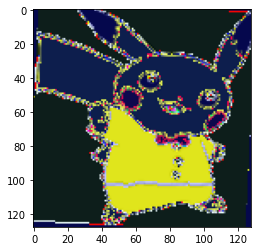

In [163]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage

for i, data in enumerate(train_loader):
    img = data[0][0,:] 
    break
print(img.size())
print("max: {}, min: {}".format(np.max(img.numpy()), np.min(img.numpy())))
plt.imshow(to_img(img))

In [19]:
import torch
# GPU 환경 설정
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == 'cuda':
  torch.cuda.manual_seed_all(777)

In [20]:
# input size 알아내기
train_data[0][0].shape

torch.Size([3, 128, 128])

## **vae**

In [36]:
class VAE(nn.Module):
  def __init__(self):
    super(VAE, self).__init__()

    # encoder part
    self.encoder = nn.Sequential(
        # encoder input size = (128, 128), channel = 3
        nn.Conv2d(3, 32, kernel_size=2, stride=2), # (3, 128, 128) -> (32, 64, 64)
        nn.BatchNorm2d(32),  
        nn.LeakyReLU(),  
        nn.Dropout(p=0.25),
        
        nn.Conv2d(32, 64, kernel_size=2, stride = 2), # (32, 64, 64) -> (64, 32, 32)  
        nn.BatchNorm2d(64),  
        nn.LeakyReLU(),    
        nn.Dropout(p=0.25),

        nn.Conv2d(64, 64, kernel_size=2, stride=2),   # (64, 32, 32) -> (64, 16, 16)
        nn.BatchNorm2d(64),   
        nn.LeakyReLU(), 
        nn.Dropout(p=0.25),

        nn.Conv2d(64, 64, kernel_size=2, stride=2),   # (64, 16, 16) -> (64, 8, 8)
        nn.BatchNorm2d(64),   
        nn.LeakyReLU(), 
        nn.Dropout(p=0.25),

        nn.Flatten()
        # output size = 8*8*64 = 4096 = h_dim        
    )
    self.fc_mu = nn.Linear(4096, 20) # 잠재공간의 차원 z_dim : 20으로 설정
    self.fc_log_var = nn.Linear(4096, 20)
    self.fc_decode = nn.Linear(20, 4096)

    # decoder part
    self.decoder = nn.Sequential(
        # decoder input size = (128, 128)

        nn.ConvTranspose2d(64, 64 ,kernel_size=2, stride=2), # (64, 8, 8) -> (64, 16, 16)
        nn.BatchNorm2d(64),
        nn.LeakyReLU(),
        nn.Dropout(p=0.25),

        nn.ConvTranspose2d(64, 64 ,kernel_size=2, stride=2),# (64, 16, 16) -> (64, 32, 32)
        nn.BatchNorm2d(64),
        nn.LeakyReLU(),
        nn.Dropout(p=0.25),

        nn.ConvTranspose2d(64, 32 ,kernel_size=2, stride=2),# (64, 32, 32) -> (32, 64, 64)
        nn.BatchNorm2d(32),
        nn.LeakyReLU(),
        nn.Dropout(p=0.25),
        
        nn.ConvTranspose2d(32, 3 ,kernel_size=2, stride=2),# (32, 64, 64) -> (3, 128, 128)
        nn.Sigmoid(),
    )
  def encode(self, x):
    h = self.encoder(x)
    # print(h.shape)  # (batch_size, 4096)
    mu, log_var = self.fc_mu(h), self.fc_log_var(h)
    z = self.reparameterize(mu, log_var)
    return z, mu, log_var

  def reparameterize(self, mu, log_var):
    sigma = torch.exp(0.5*log_var)  # 교재 p108 참고
    epsilon = torch.randn_like(sigma) # sigma와 같은 크기의 정규분포 랜덤 텐서 생성
    return mu + sigma * epsilon

  def decode(self, z):
    z = self.fc_decode(z)
    z = self.decoder(z.view(z.size(0), 64, 8, 8)) # Unflatten 대신 직접 reshape
    return z

  def forward(self, x):
    z, mu, log_var = self.encode(x)
    z = self.decode(z)
    return z, mu, log_var

In [37]:
# model 내 input-output size 맞춘 것 확인

tst_model = VAE().to(device)
tst_input = (torch.rand(1, 3, 128, 128)).to(device)
tst_out = tst_model(tst_input)

print(len(tst_out)) # (z, mu, log_var) 3가지 텐서를 담고 있는 tuple 형
tst_gen_img, tst_mu, tst_log_var = tst_out
print("생성된 이미지 크기 : ", tst_gen_img.shape)
print("mu 크기 : ", tst_mu.shape)
print("log_var 크기 :",tst_log_var.shape)

tst_z, _, _ = tst_model.encode(tst_input)
print("잠재공간 크기 :",tst_z.shape)

3
생성된 이미지 크기 :  torch.Size([1, 3, 128, 128])
mu 크기 :  torch.Size([1, 20])
log_var 크기 : torch.Size([1, 20])
잠재공간 크기 : torch.Size([1, 20])


## **Loss function**

교재에서 손실함수는 보통 RMSE(평균 제곱근 오차)와 BCE(이진 크로스 엔트로피)를 보통 사용한다고 하였는데 BCE는 극단적으로 나쁜 예측에 큰 벌칙을 부여하기 때문에 픽셀 예측값을 중간 범위로 만드는 경향이 있고, 이는 실제 이미지처럼 보이지 않게 만든다고 한다. 따라서 RMSE를 사용하였다.

In [46]:
# 최종 return reconstruction loss + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
  recon_x, x = recon_x.view(-1), x.view(-1) # 안 넣으면 오류남
  rmse_loss = torch.sqrt(torch.mean(torch.square(x - recon_x)) + 1e-7)
  kld = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
  return rmse_loss, kld, rmse_loss + kld

In [47]:
# loss function 크기 테스트
r, k, l = loss_function(tst_gen_img, tst_input, tst_mu, tst_log_var )
print(r)
print(k)
print(l)

tensor(0.3372, grad_fn=<SqrtBackward>)
tensor(2.8981, grad_fn=<MulBackward0>)
tensor(3.2353, grad_fn=<AddBackward0>)


## **save model**

In [103]:
# 중간세이브 코드
import os
def save_model(model, save_dir, epoch, loss, file_name = 'pokemon_vae_param.pt'):
  save_path = save_dir + '/' + file_name
  check_point = {'model_state_dict':model.state_dict(),
                 'epoch': epoch,
                 'optimizer_state_dict': optimizer.state_dict(),
                 'loss': loss
                 }
  if not os.path.exists(save_dir):
    os.mkdir(save_dir)
  torch.save(check_point, save_path)

In [109]:
save_model(model, '/content/gdrive/My Drive/Colab Notebooks/vae_project/model', 1, 3)

In [110]:
checkpoint = torch.load('/content/gdrive/My Drive/Colab Notebooks/vae_project/model/pokemon_vae_param.pt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

In [111]:
model.train()

VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(2, 2), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout(p=0.25, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(2, 2), stride=(2, 2))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): Dropout(p=0.25, inplace=False)
    (8): Conv2d(64, 64, kernel_size=(2, 2), stride=(2, 2))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.01)
    (11): Dropout(p=0.25, inplace=False)
    (12): Conv2d(64, 64, kernel_size=(2, 2), stride=(2, 2))
    (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): LeakyReLU(negative_slope=0.01)
    (15): Dropout(p=0.25, inplace=False)
    (16): Flatten()
  )
  (fc_mu): Linear(in_features

## **training**

In [141]:
learning_rate = 0.0005
epochs = 30

In [142]:
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

def train(epoch):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = model(data)
        r, k, loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss
        optimizer.step()
        
        if batch_idx % 10 == 0:
          print("Epoch[{}/{}][Step{}/{}] Loss: {:.3f}".format(epoch, epochs, batch_idx * len(train_data), len(train_loader.dataset) loss.item()))
    save_model(model, '/content/gdrive/My Drive/Colab Notebooks/vae_project/model', epoch, loss) # 한 에폭 진행할 때마다 중간저장

In [143]:
def test():
    model.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            recon, mu, log_var = model(data)
            
            # sum up batch loss
            r, k, loss = loss_function(recon, data, mu, log_var)
            test_loss += loss
        
    test_loss /= len(test_loader.dataset)
    print('Test set loss: {:.4f}'.format(test_loss))

In [144]:
for epoch in range(1, epochs+1):
    train(epoch)
    test()

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch[2/30][Step1/10] Loss: 107.465
Test set loss: 0.1062


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch[3/30][Step1/10] Loss: 3.318
Test set loss: 0.0529


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch[4/30][Step1/10] Loss: 1.520
Test set loss: 0.0420


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch[5/30][Step1/10] Loss: 1.355
Test set loss: 0.0335


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch[6/30][Step1/10] Loss: 1.102
Test set loss: 0.0307
Epoch[7/30][Step1/10] Loss: 0.957


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Test set loss: 0.0287


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch[8/30][Step1/10] Loss: 0.920
Test set loss: 0.0275


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch[9/30][Step1/10] Loss: 0.836
Test set loss: 0.0268


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch[10/30][Step1/10] Loss: 0.798
Test set loss: 0.0264


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch[11/30][Step1/10] Loss: 0.831
Test set loss: 0.0262


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch[12/30][Step1/10] Loss: 0.788
Test set loss: 0.0259


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch[13/30][Step1/10] Loss: 0.815
Test set loss: 0.0256


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch[14/30][Step1/10] Loss: 0.786
Test set loss: 0.0255


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch[15/30][Step1/10] Loss: 0.771
Test set loss: 0.0254


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch[16/30][Step1/10] Loss: 0.762
Test set loss: 0.0251


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch[17/30][Step1/10] Loss: 0.793
Test set loss: 0.0251


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch[18/30][Step1/10] Loss: 0.802
Test set loss: 0.0250


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch[19/30][Step1/10] Loss: 0.798
Test set loss: 0.0249


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch[20/30][Step1/10] Loss: 0.793
Test set loss: 0.0247


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch[21/30][Step1/10] Loss: 0.719
Test set loss: 0.0248


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch[22/30][Step1/10] Loss: 0.864
Test set loss: 0.0246


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch[23/30][Step1/10] Loss: 0.768
Test set loss: 0.0246


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch[24/30][Step1/10] Loss: 0.793
Test set loss: 0.0246


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch[25/30][Step1/10] Loss: 0.812
Test set loss: 0.0244


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch[26/30][Step1/10] Loss: 0.771
Test set loss: 0.0244


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch[27/30][Step1/10] Loss: 0.735
Test set loss: 0.0243


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch[28/30][Step1/10] Loss: 0.783
Test set loss: 0.0244


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch[29/30][Step1/10] Loss: 0.789
Test set loss: 0.0244


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch[30/30][Step1/10] Loss: 0.791
Test set loss: 0.0243


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch[31/30][Step1/10] Loss: 0.755
Test set loss: 0.0242


In [145]:
import matplotlib.pyplot as plt
import numpy as np

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


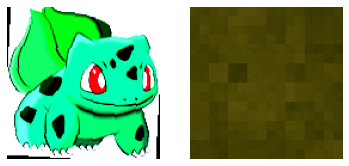

In [164]:
data_idx = 15
# 이미지 생성

model = model.eval()

original_img, label = train_data[data_idx]
original_img = original_img.reshape(1,3,128,128).to(device)
gen_img, _, _ = model(original_img)

# 이미지 출력 by matplotlib, numpy
fig = plt.figure()

original_img = original_img[0].cpu().numpy()
sub = fig.add_subplot(1, 2, 1)
sub.axis('off')
sub.imshow(np.transpose(original_img, (1, 2, 0))) # tensor에서 ndarray로 바꿔줘야 imshow에 넣을 수 있는 듯?

gen_img = gen_img[0].cpu().detach().numpy()
sub = fig.add_subplot(1, 2, 2)
sub.axis('off')
sub.imshow(np.transpose(gen_img, (1, 2, 0))) # grad가 포함된 어쩌구는 안 된대서 detach().numpy까지 시도함.